In [54]:
from qiskit import IBMQ, pulse, schedule
from qiskit.circuit import QuantumCircuit, Gate, Parameter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from sympy import *
from sympy.physics.quantum import *

import numpy as np

import warnings

warnings.filterwarnings('ignore')

In [55]:
IBMQ.load_account()  # load if no backend satisfies
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')
qubit = 0
backend_config = backend.configuration()
dt = backend_config.dt
backend_defaults = backend.defaults()

configrc.store_credentials:WARNING:2022-08-23 13:33:25,534: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-08-23 13:33:26,441: Credentials are already in use. The existing account in the session will be replaced.


In [56]:
f01 = 4925170000.0
f12 = 4581552617.648945

d12_duration = 544
d12_amplitude = 0.10879003883868105
d12_sigma = 40

d01_duration = 544
d01_sigma = 67
d01_amplitude = 0.07999888439750123

# $X_\pi^{(01)}$ instructions

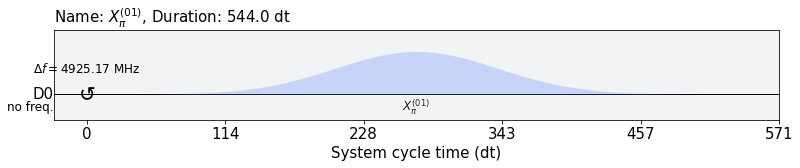

In [57]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as inst_xpi01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=d01_duration,
                              amp=d01_amplitude,
                              sigma=d01_sigma,
                              name=r'$X_{\pi}^{(01)}$'), drive_chan)

xpi01 = Gate('xp01', 1, [])
inst_xpi01.draw()

# $X_\pi^{(12)}$ instructions

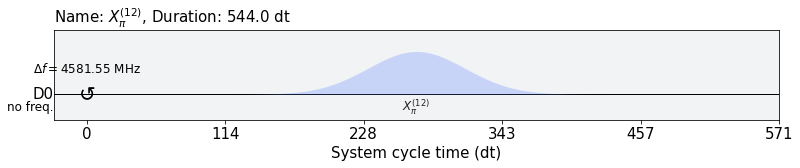

In [58]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as inst_xpi12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=d12_duration,
                              amp=d12_amplitude,
                              sigma=d12_sigma,
                              name=r'$X_{\pi}^{(12)}$'), drive_chan)

xpi12 = Gate('xp12', 1, [])
inst_xpi12.draw()

Parameters

In [59]:
theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = (1.5707957078968966,
                                      1.9106338956261688,
                                      1.5707957078968966,
                                      -2.6179938779914935,
                                      -2.617993877991495,
                                      -1.047197639327731,
                                      2.0943951023931953,
                                      -3.141592653589794,
                                      -6.806784170909019)

In [60]:
phi_1

-2.6179938779914935

# Hadamard pulse instruction

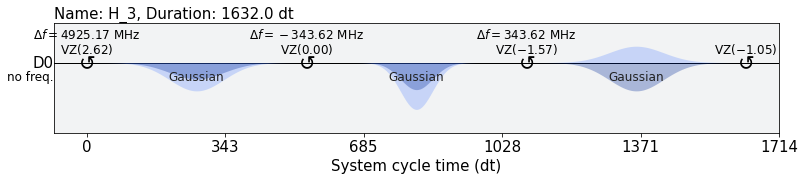

In [61]:
phase01 = 0
phase12 = 0
with pulse.build(backend=backend, default_alignment='sequential', name=r'H_3') as Hadamard1:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(phase01 + phi_1, drive_chan):
        pulse.play(pulse.Gaussian(duration=d01_duration,
                                  amp=(theta_1/np.pi)*d01_amplitude,
                                  sigma=d01_sigma), drive_chan)
    pulse.set_frequency(f12, drive_chan)
    with pulse.phase_offset(phase12 + phi_2, drive_chan):
        pulse.play(pulse.Gaussian(duration=d12_duration,
                                  amp=(theta_2/np.pi)*d12_amplitude,
                                  sigma=d12_sigma), drive_chan)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(phi_3, drive_chan):
        pulse.play(pulse.Gaussian(duration=d01_duration,
                                  amp=(theta_3/np.pi)*d01_amplitude,
                                  sigma=d01_sigma), drive_chan)
Hadamard1.draw()

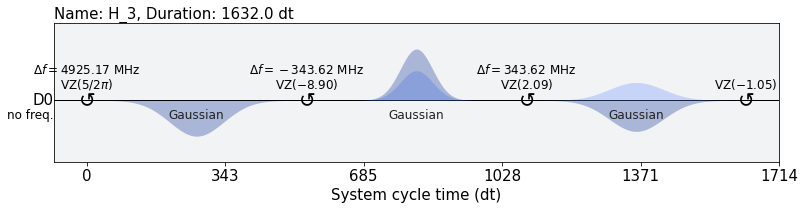

In [62]:
phase01 += phi_5 - phi_4
phase12 += phi_5 - phi_6
with pulse.build(backend=backend, default_alignment='sequential', name=r'H_3') as Hadamard2:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(phase01 + phi_1, drive_chan):
        pulse.play(pulse.Gaussian(duration=d01_duration,
                                  amp=(theta_1/np.pi)*d01_amplitude,
                                  sigma=d01_sigma), drive_chan)
    pulse.set_frequency(f12, drive_chan)
    with pulse.phase_offset(phase12 + phi_2, drive_chan):
        pulse.play(pulse.Gaussian(duration=d12_duration,
                                  amp=(theta_2/np.pi)*d12_amplitude,
                                  sigma=d12_sigma), drive_chan)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(phi_3, drive_chan):
        pulse.play(pulse.Gaussian(duration=d01_duration,
                                  amp=(theta_3/np.pi)*d01_amplitude,
                                  sigma=d01_sigma), drive_chan)
Hadamard2.draw()

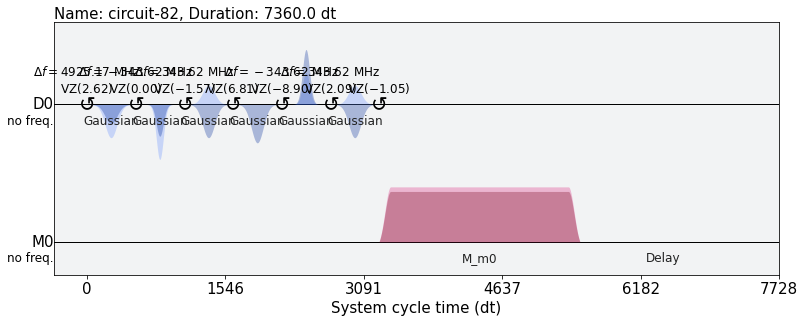

In [68]:
qc = QuantumCircuit(1,1)

H1 = Gate('Hadamard 1', 1, [])
H2 = Gate('Hadamard 2', 1, [])

qc.append(H1, [0])
qc.append(H2, [0])
qc.measure(0,0)
qc.add_calibration(H1, (0,), Hadamard1, [])
qc.add_calibration(H2, (0,), Hadamard2, [])

sched = schedule(qc, backend)
sched.draw()

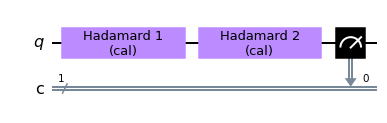

In [71]:
qc.draw(output = 'mpl')

In [73]:
num_shots = 2**13

job = backend.run(qc,
                  meas_level=2,
                  meas_return='avg',
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


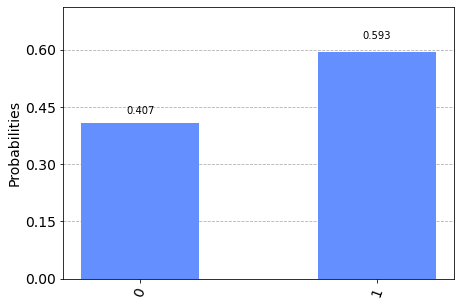

In [74]:
counts = job.result().get_counts()
plot_histogram(counts)